### **Load libraries**

In [70]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
import importlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR
from mgarch import mgarch

import itertools
import random

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [73]:
rets = pd.read_csv('all_rets.csv', index_col=0)
stocks = pd.read_csv('all_stocks.csv', index_col=0)
selected_stocks = pd.read_csv('selected_stocks_rets.csv', index_col=0).columns

rets.index = pd.to_datetime(rets.index).to_period('W')
stocks.index = pd.to_datetime(stocks.index).to_period('W')

In [74]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

In [75]:
rets_backup = rets.copy(); stocks_backup = stocks.copy()

# Determine the dataset size
# Uncomment if a smaller dataset is desired
# rets = rets.loc['2021-01-01':]
# stocks = stocks.loc['2021-01-01':]

# **Estimation of future Moving Average Returns**

## **Analysis of stationarity**

In [76]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock])[1], 4)}')

# All return series are stationary, however, differentiating by first order seems to result in better models

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ETB.CL series: 0.0
Augmented Dicke

## **Model 1: Annualized Yearly Returns from the Last 3 Years**

In [77]:
# Compare with the expected returns calculated from historical returns
historical_annualized_returns = rk.summary_stats(rets.iloc[-162:], periods_per_year=periods_per_year)['Annualized Return']
historical_annualized_returns

BCOLOMBIA.CL     0.193037
BOGOTA.CL       -0.103812
BVC.CL           0.174349
CELSIA.CL        0.094839
CEMARGOS.CL      0.311091
CNEC.CL         -0.470440
CONCONCRET.CL    0.182272
CORFICOLCF.CL   -0.078328
ECOPETROL.CL    -0.073104
ENKA.CL         -0.056978
ETB.CL          -0.306639
EXITO.CL        -0.074239
GEB.CL           0.219333
GRUBOLIVAR.CL   -0.011782
GRUPOARGOS.CL    0.271462
GRUPOAVAL.CL    -0.092334
GRUPOSURA.CL     0.060220
HCOLSEL.CL       0.084768
ICOLCAP.CL       0.059771
ISA.CL           0.023357
MINEROS.CL       0.324309
NUTRESA.CL       0.553184
PFAVAL.CL       -0.073436
PFBCOLOM.CL      0.161186
PFCORFICOL.CL   -0.008807
PFDAVVNDA.CL    -0.138107
PFGRUPOARG.CL    0.339692
PFGRUPSURA.CL    0.317601
PROMIGAS.CL      0.033981
TERPEL.CL        0.246184
AAPL             0.138518
AMZN             0.225196
BAC              0.120640
BRK-B            0.152394
C                0.238794
CBU7.L           0.024273
CENCOSUD.SN      0.370094
CHILE.SN         0.246962
CSPX.L      

## **Model 2: VAR bagging**

In [78]:
# Get the 1st order integration for the returns series
rets_integrated = (rets - rets.shift(1)).dropna()

In [79]:
symbols_list = list(rets.columns.values) # List of all available stock symbols
n_iterations = 2000 # The number of iterations of VAR models to perform
set_size = 10 # Number of symbols modeled in each iteration
periods_to_forecast = 4 # Number of periods to forecast

# Initialize an empty list of sets of stock symbols
iterations_symbols = []

for i in range(n_iterations):
    # For each iteration of the model, select a random set of 'set_size' stock symbols
    iterations_symbols.append(random.sample(symbols_list, set_size))

In [80]:
# Initialize a dictionary of dictionaries where the results of each iteration will be stored
prediction_results = {symbol: {} for symbol in symbols_list}

for i, symbols_selection in enumerate(iterations_symbols):
    # In each iteration, generate a dataset with the stocks selected for the iteration only
    subset_df = rets_integrated[symbols_selection]
    
    # Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
    varmod = VAR(subset_df)
    lag_sel = varmod.select_order(10)
    
    # Select the best number of lags according to the AIC criterion
    n_lags = lag_sel.aic
    print(f'Iteration {i}, ideal_n_lags: {n_lags}')
    
    # Fit the model for the iteration
    var_model = VAR(subset_df).fit(maxlags=n_lags, trend='c')

    # Predict the following 'periods_to_forecast' periods
    predictions = var_model.forecast(subset_df.iloc[-n_lags:].values, periods_to_forecast)
    predictions = pd.DataFrame(predictions)

    # Append the predicted values to the 'prediction_results' dictionary
    for l in predictions:
        prediction_results[symbols_selection[l]][i] = predictions[l]
    print(f'Iteration {i+1} finished')

Iteration 0, ideal_n_lags: 10
Iteration 1 finished
Iteration 1, ideal_n_lags: 10
Iteration 2 finished
Iteration 2, ideal_n_lags: 7
Iteration 3 finished
Iteration 3, ideal_n_lags: 8
Iteration 4 finished
Iteration 4, ideal_n_lags: 8
Iteration 5 finished
Iteration 5, ideal_n_lags: 8
Iteration 6 finished
Iteration 6, ideal_n_lags: 8
Iteration 7 finished
Iteration 7, ideal_n_lags: 6
Iteration 8 finished
Iteration 8, ideal_n_lags: 7
Iteration 9 finished
Iteration 9, ideal_n_lags: 7
Iteration 10 finished
Iteration 10, ideal_n_lags: 10
Iteration 11 finished
Iteration 11, ideal_n_lags: 8
Iteration 12 finished
Iteration 12, ideal_n_lags: 8
Iteration 13 finished
Iteration 13, ideal_n_lags: 9
Iteration 14 finished
Iteration 14, ideal_n_lags: 6
Iteration 15 finished
Iteration 15, ideal_n_lags: 9
Iteration 16 finished
Iteration 16, ideal_n_lags: 10
Iteration 17 finished
Iteration 17, ideal_n_lags: 7
Iteration 18 finished
Iteration 18, ideal_n_lags: 8
Iteration 19 finished
Iteration 19, ideal_n_lags:

In [81]:
import warnings
warnings.filterwarnings('ignore')

# Copy the 'prediction_results' dictionary to invert the integration of the copy and set the index for predicted dates
prediction_results_processed = prediction_results.copy()
for symbol in prediction_results:
    # For each stock in 'prediction_results', convert the predictions into a dataframe
    pred_df = pd.DataFrame(prediction_results[symbol])

    # Get the average predictions for each day
    pred_series = pred_df.mean(axis=1)

    # Invert the integration by taking the last actual returns and add it to the predictions, then do a cumulative sum
    pred_series = rets[symbol][-1] + pred_series.cumsum()
    
    # Generate an index for the future dates
    #future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=1, unit='d'), periods=periods_to_forecast)
    future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=7, unit='d'), periods=periods_to_forecast, freq='W-SUN').to_period('W') # Weekly
    pred_series.index = future_dates
    
    # Add the series of average predicted returns for the stock to the 'prediction_results_processed' dictionary
    prediction_results_processed[symbol] = pred_series

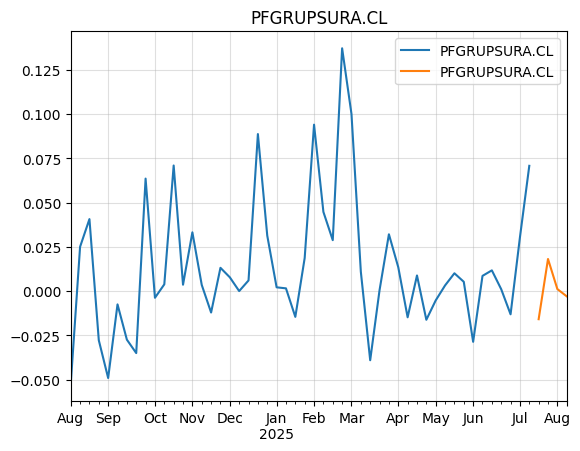

In [82]:
# Visualize the predictions of any stock
symbol = 'PFGRUPSURA.CL'
concat_df = pd.concat([rets[symbol][-50:], pd.DataFrame(prediction_results_processed[symbol], columns=[symbol])], axis=1)

concat_df.plot()
#prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [83]:
# Calculate the exptected annual returns for each stock
# Initialize an empty dictionary where the returns will be stored
expected_annualized_rets = {}

for symbol in prediction_results_processed:
    # Calculate the weighted average returns from the predictions and then annualize them
    # Uncomment the method of weighting for the averaging and annualization of the returns
    
    ### Raw predicted returns annualized
    # expected_annualized_returns = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
    
    ### Linearly decaying weighted returns annualized
    # weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    # linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
    # expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1

    ### Exponentially decaying weighted returns annualized
    weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    lambda_ = 0.2
    exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()
    expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*exponential_decay_w))**periods_per_year - 1

    expected_annualized_rets[symbol] = expected_annualized_returns

In [84]:
# Predictions of annualized returns for the VAR Bagging model
var_bagging_expected_annualized_rets = expected_annualized_rets
pd.Series(var_bagging_expected_annualized_rets)

BCOLOMBIA.CL    -0.258623
BOGOTA.CL        0.068566
BVC.CL          -0.434300
CELSIA.CL        0.379760
CEMARGOS.CL     -0.032435
CNEC.CL         -0.758424
CONCONCRET.CL   -0.604649
CORFICOLCF.CL   -0.050978
ECOPETROL.CL    -0.280947
ENKA.CL         -0.047159
ETB.CL           0.756548
EXITO.CL         6.296249
GEB.CL           0.292656
GRUBOLIVAR.CL    0.126238
GRUPOARGOS.CL    0.404628
GRUPOAVAL.CL    -0.286341
GRUPOSURA.CL     1.401252
HCOLSEL.CL      -0.072007
ICOLCAP.CL       0.002296
ISA.CL          -0.339479
MINEROS.CL       0.242644
NUTRESA.CL       0.129656
PFAVAL.CL       -0.366658
PFBCOLOM.CL     -0.235512
PFCORFICOL.CL   -0.073092
PFDAVVNDA.CL    -0.191765
PFGRUPOARG.CL    0.181082
PFGRUPSURA.CL   -0.033560
PROMIGAS.CL     -0.003483
TERPEL.CL        0.136201
AAPL             0.259955
AMZN             1.338957
BAC              0.429043
BRK-B           -0.511447
C                1.737599
CBU7.L           0.120919
CENCOSUD.SN     -0.255518
CHILE.SN        -0.289238
CSPX.L      

## **Model 3: Transformer Neural Network**

### **Generate the data**

In [85]:
data = rets.values

# Prepare the data for training
def create_dataset(data, time_window=1):
    X, Y = [], []

    for i in range(len(data)-time_window):
        X.append(data[i:(i+time_window)])
        Y.append(data[i + time_window])
    return np.array(X), np.array(Y)

# Generate the sequences of data
time_window = 54
X, Y = create_dataset(data, time_window)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (467, 54, 54)
Shape of Y: (467, 54)


### **Implement Positional Encoding**

In [86]:
# Positional encoding represents the data in time steps
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.sequence_length = sequence_length
        self.d_model = d_model

    def call(self, inputs):
        positions = np.arange(self.sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-np.log(10000.0) / self.d_model))
        pos_encoding = np.zeros((self.sequence_length, self.d_model))
        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        pos_encoding[:, 1::2] = np.cos(positions * div_term)
        return inputs + tf.convert_to_tensor(pos_encoding, dtype=tf.float32)

### **Implement the Transformer Encoder block**

In [87]:
# Implement Multi-Head Self-Attention, Layer Normalization, and Feed-Forward Networks
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self-Attention
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    return x

### **Build the Transformer Model**

In [88]:
# Function that builds the model that will take inputs, encode them, and then make a prediction for the input_shape[1] items
def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, dropout=0.1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Positional Encoding
    x = PositionalEncoding(sequence_length=input_shape[0], d_model=input_shape[1])(inputs)
    
    # Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling over time dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output Layer (input_shape[1]-dimensional vector)
    outputs = tf.keras.layers.Dense(input_shape[1])(x)

    # Build Model
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["mae", tf.keras.metrics.RootMeanSquaredError]
    )
    
    return model

### **Train the Model**

In [89]:
input_shape = (time_window, X.shape[2]) # Shape of each input
head_size = 128
num_heads = 8
ff_dim = 512
num_transformer_blocks = 6
dropout = 0.1

model = build_transformer_model(input_shape)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 54, 54)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_encoding_2         │ (None, 54, 54)            │               0 │ input_layer_2[0][0]        │
│ (PositionalEncoding)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_4        │ (None, 54, 54)            │          56,118 │ positional_encoding_2[0][… │
│ (MultiHeadAttention)          │                           │                 │ positional_encoding_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_8 (Add)                   │ (None, 54, 54)            │               0 │ multi_head_attention_4[0]… │
│                               │                           │                 │ positional_encoding_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_8         │ (None, 54, 54)            │             108 │ add_8[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 54, 128)           │           7,040 │ layer_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 54, 54)            │           6,966 │ dense_10[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_9 (Add)                   │ (None, 54, 54)            │               0 │ layer_normalization_8[0][… │
│                               │                           │                 │ dense_11[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_9         │ (None, 54, 54)            │             108 │ add_9[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_5        │ (None, 54, 54)            │          56,118 │ layer_normalization_9[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_10 (Add)                  │ (None, 54, 54)            │               0 │ multi_head_attention_5[0]… │
│                               │                           │                 │ layer_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_10        │ (None, 54, 54)            │             108 │ add_10[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 54, 128)           │           7,04

 Total params: 143,650 (561.13 KB)

 Trainable params: 143,650 (561.13 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Train the model
history = model.fit(
    X, Y,
    epochs=50,
    batch_size=32
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6176 - mae: 0.5805 - root_mean_squared_error: 0.7828
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1594 - mae: 0.3131 - root_mean_squared_error: 0.3981
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0549 - mae: 0.1851 - root_mean_squared_error: 0.2338
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0259 - mae: 0.1229 - root_mean_squared_error: 0.1607
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0139 - mae: 0.0852 - root_mean_squared_error: 0.1179
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0081 - mae: 0.0660 - root_mean_squared_error: 0.0899
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0054 - mae: 0.0536 - root_mean_squared_error: 0.0734
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0037 - mae: 0.0441 - root_mean_squared_error: 0.0611
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - mae: 0.0388 - root_m

### **Perform predictions**

In [91]:
# Generate the input for the prediction of future period

# Add a dummy array for the future period,
# so that the generate_dataset function will capture the latest observation in the last sequence
data_preds = data.copy()
data_preds = np.concatenate((data_preds, np.expand_dims(np.zeros_like(data_preds[-1]), axis=0)))

X_, Y_ = create_dataset(data_preds, time_window)

In [92]:
periods_to_forecast = 4
preds = []
pred_inputs = np.expand_dims(X_[-1], axis=0)

for i in range(periods_to_forecast):
    prediction = model.predict(pred_inputs)
    preds.append(prediction[0])
    pred_inputs = np.concatenate((pred_inputs[0][1:], np.expand_dims(prediction[0], axis=0)))
    pred_inputs = np.expand_dims(pred_inputs, axis=0)

preds = np.array(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [93]:
preds_df = pd.DataFrame(preds, columns=rets.columns)

future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=7, unit='d'), periods=periods_to_forecast, freq='W-SUN').to_period('W') # Weekly
preds_df = pd.DataFrame(preds, columns=rets.columns, index=future_dates)

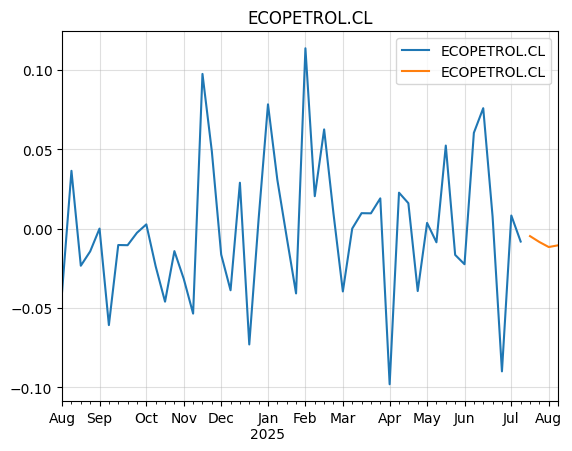

In [94]:
# Visualize the predictions of any stock
symbol = 'ECOPETROL.CL'#'PFGRUPSURA.CL'
concat_df = pd.concat([rets[symbol][-50:], preds_df[symbol]], axis=1)

concat_df.plot()
#prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [95]:
# Calculate the exptected annual returns for each stock
# Initialize an empty dictionary where the returns will be stored
expected_annualized_rets = {}

for symbol in preds_df.columns:
    # Calculate the weighted average returns from the predictions and then annualize them
    # Uncomment the method of weighting for the averaging and annualization of the returns
    
    ### Raw predicted returns annualized
    # expected_annualized_returns = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
    
    ### Linearly decaying weighted returns annualized
    # weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    # linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
    # expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1

    ### Exponentially decaying weighted returns annualized
    weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    lambda_ = 0.2
    exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()
    expected_annualized_returns = (1 + np.sum(preds_df[symbol]*exponential_decay_w))**periods_per_year - 1

    expected_annualized_rets[symbol] = expected_annualized_returns

In [96]:
# Predictions of annualized returns for the Transformer model
transformer_expected_annualized_rets = expected_annualized_rets
pd.Series(transformer_expected_annualized_rets)

BCOLOMBIA.CL     0.492884
BOGOTA.CL        0.291248
BVC.CL          -0.045929
CELSIA.CL       -0.219627
CEMARGOS.CL     -0.039746
CNEC.CL          0.190282
CONCONCRET.CL    0.295218
CORFICOLCF.CL    0.705776
ECOPETROL.CL    -0.362961
ENKA.CL         -0.291354
ETB.CL          -0.487347
EXITO.CL        -0.728672
GEB.CL           0.482707
GRUBOLIVAR.CL    1.744251
GRUPOARGOS.CL    0.430672
GRUPOAVAL.CL    -0.055264
GRUPOSURA.CL    -0.458156
HCOLSEL.CL       0.237010
ICOLCAP.CL      -0.124900
ISA.CL           0.359899
MINEROS.CL       0.603130
NUTRESA.CL      -0.129187
PFAVAL.CL        0.735273
PFBCOLOM.CL      0.591622
PFCORFICOL.CL   -0.517954
PFDAVVNDA.CL     0.528450
PFGRUPOARG.CL    0.568812
PFGRUPSURA.CL   -0.196999
PROMIGAS.CL      1.310147
TERPEL.CL       -0.196037
AAPL             3.028166
AMZN             0.189556
BAC              2.559092
BRK-B            0.485060
C                0.364498
CBU7.L          -0.460762
CENCOSUD.SN     -0.262975
CHILE.SN         0.898100
CSPX.L      

In [97]:
# Compare returns of different models:
"""
pd.Series(historical_annualized_returns)
pd.Series(var_bagging_expected_annualized_rets)
pd.Series(transformer_expected_annualized_rets)
"""

'\npd.Series(historical_annualized_returns)\npd.Series(var_bagging_expected_annualized_rets)\npd.Series(transformer_expected_annualized_rets)\n'

In [98]:
# Uncomment the predictions of the model that was preferred
# expected_returns = historical_annualized_returns
# expected_returns = var_bagging_expected_annualized_rets
expected_returns = transformer_expected_annualized_rets

# **Covariance matrix estimation**

## **Model 1: Historical Covariance Matrix from the last 3 years**

In [67]:
# Simple long-term covariance
covmat = rets.iloc[-periods_per_year * 3:].cov()
covmat

,BCOLOMBIA.CL,BOGOTA.CL,BVC.CL,CELSIA.CL,CEMARGOS.CL,CNEC.CL,CONCONCRET.CL,CORFICOLCF.CL,ECOPETROL.CL,ENKA.CL,ETB.CL,EXITO.CL,GEB.CL,GRUBOLIVAR.CL,GRUPOARGOS.CL,GRUPOAVAL.CL,GRUPOSURA.CL,HCOLSEL.CL,ICOLCAP.CL,ISA.CL,MINEROS.CL,NUTRESA.CL,PFAVAL.CL,PFBCOLOM.CL,PFCORFICOL.CL,PFDAVVNDA.CL,PFGRUPOARG.CL,PFGRUPSURA.CL,PROMIGAS.CL,TERPEL.CL,AAPL,AMZN,BAC,BRK-B,C,CBU7.L,CENCOSUD.SN,CHILE.SN,CSPX.L,EIMI.L,F,FALABELLA.SN,GE,GOOGL,JETS,JNJ,JPM,META,NKE,NVDA,PBR,PFE,SGLD.L,VOO
BCOLOMBIA.CL,0.002306,0.000596,0.000123,0.000380,2.877004e-04,0.000415,0.000427,0.001136,0.000611,5.365179e-04,0.000068,0.000359,0.000383,0.000490,0.000425,0.000494,0.000281,0.000572,0.000819,7.824277e-04,0.000527,6.643486e-05,0.000894,0.001498,0.000933,0.000598,6.005692e-04,0.000683,0.000369,0.000335,-0.000041,-0.000006,0.000385,0.000217,5.424131e-04,3.558874e-05,0.000084,0.000251,0.000130,0.000314,0.000722,0.000058,0.000255,0.000028,0.000144,0.000027,0.000323,7.637707e-05,0.000412,-1.994434e-04,0.000398,0.000048,0.000120,0.000101
BOGOTA.CL,0.000596,0.002087,0.000015,0.000474,6.965802e-05,0.000473,0.000515,0.000765,0.000204,-2.001961e-04,0.000060,0.000447,0.000585,0.000331,0.000151,0.000411,-0.000194,0.000334,0.000464,1.639856e-04,0.000148,1.844495e-04,0.000782,0.000590,0.000334,0.000421,1.465975e-04,0.000028,-0.000059,0.000207,0.000047,0.000234,-0.000008,0.000060,7.210681e-05,6.206423e-05,0.000026,0.000016,0.000122,0.000268,0.000305,0.000026,0.000303,0.000130,0.000121,0.000134,0.000022,4.709509e-04,0.000418,-1.215781e-04,0.000445,0.000231,0.000199,0.000088
BVC.CL,0.000123,0.000015,0.001972,0.000622,2.837523e-04,-0.000099,0.000061,0.000233,0.000090,6.124745e-04,0.000341,0.000067,0.000726,0.000585,0.000271,0.000105,0.000461,0.000095,-0.000022,1.098964e-04,0.000580,-6.442172e-04,0.000133,0.000226,0.000246,0.000270,3.907424e-04,0.000471,0.000666,0.000244,0.000096,0.000050,-0.000076,-0.000027,-2.618264e-05,6.134142e-05,0.000001,0.000105,-0.000005,-0.000046,0.000034,-0.000038,0.000029,0.000355,-0.000142,0.000058,-0.000133,-4.657108e-05,0.000093,-1.490218e-04,0.000105,-0.000063,0.000073,0.000016
CELSIA.CL,0.000380,0.000474,0.000622,0.002116,7.155932e-04,0.000213,0.000602,0.000638,0.000568,5.778902e-04,0.000497,0.000557,0.001239,0.001121,0.000817,0.000074,0.000622,0.000403,0.000471,2.712607e-04,0.000772,-8.245360e-04,0.000187,0.000564,0.000685,0.000981,9.567848e-04,0.001251,0.000690,0.000344,-0.000030,-0.000005,0.000183,0.000055,2.015550e-04,2.918336e-05,-0.000051,0.000021,0.000115,0.000182,0.000314,-0.000133,0.000283,0.000257,0.000075,-0.000025,0.000142,2.959519e-04,0.000139,1.811321e-04,0.000181,-0.000052,0.000269,0.000120
CEMARGOS.CL,0.000288,0.000070,0.000284,0.000716,2.938248e-03,-0.000051,0.000573,0.000404,0.000551,2.089958e-04,0.000566,-0.000186,0.000724,0.000292,0.001193,0.000006,0.001113,0.000344,0.000403,4.913923e-04,0.000853,-6.969319e-04,0.000098,0.000265,0.000862,0.000620,9.975023e-04,0.001070,0.000750,0.000237,-0.000100,-0.000009,0.000218,0.000137,2.677031e-04,3.084945e-05,-0.000019,-0.000058,0.000158,0.000051,0.000275,0.000014,0.000018,0.000200,0.000151,0.000133,0.000191,4.031670e-05,0.000172,3.559399e-07,0.000066,0.000029,0.000198,0.000116
CNEC.CL,0.000415,0.000473,-0.000099,0.000213,-5.097970e-05,0.003337,0.000021,0.000123,0.001037,1.174565e-05,0.000050,-0.000147,0.000016,0.000078,0.000015,0.000355,-0.000220,0.000224,0.000403,3.419667e-04,-0.000306,1.728714e-04,0.000372,0.000486,-0.000026,0.000225,2.788272e-04,0.000164,-0.000062,0.000291,0.000322,0.000271,0.000457,0.000209,4.100574e-04,5.616169e-06,0.000233,-0.000019,0.000223,0.000403,0.000718,0.000345,0.000529,0.000313,0.000336,0.000022,0.000437,2.084116e-04,0.000270,3.642473e-04,0.000770,0.000253,0.000109,0.000265
CONCONCRET.CL,0.000427,0.000515,0.000061,0.000602,5.731849e-04,0.000021,0.004628,0.000884,0.000690,3.659957e-04,0.000656,0.000616,0.000838,0.000411,0.000453,0.000449,0.000365,0.000306,0.000559,1.942658e-04,0.000498,-1.390745e-04,0.000542,0.000450,0.000666,0.000579,4.352626e-04,0.000899,0.0003

## **Model 2: Multivariate GARCH**

In [69]:
summary_stats = rk.summary_stats(rets[selected_stocks], periods_per_year=periods_per_year, riskfree_rate=0)
returns = summary_stats['Annualized Return']

# Recent covariance prediction based on recent days with GARCH model
vol = mgarch('t')
vol.fit(rets[selected_stocks])
nperiods = 4
covmat = vol.predict(nperiods)
covmat = pd.DataFrame(data=covmat['cov'], index=returns.index, columns=returns.index)

# **Export predicted returns and covariance matrix**

In [ ]:
pd.Series(expected_annualized_rets)[selected_stocks].to_csv('expected_returns.csv', header=None)

In [ ]:
covmat.to_csv('expected_covmat.csv')